In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#### Carga y preparación del conjunto de datos MNIST
Es un conjunto de dígitos escritos a mano del 0 al 9, para un modelo de aprendizaje produnfo en PyTorch.

In [3]:
transform = transforms.Compose( 
    [transforms.ToTensor(), 
     transforms.Normalize((0.5), (0.5)) 
    ])

transform = transforms.ToTensor() 
 
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, 
                                          batch_size=64, 
                                          shuffle=True) 

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid, 
                                          batch_size=64, 
                                          shuffle=True) 

In [4]:
dataiter = iter(data_loader) 
images, labels = next(dataiter) 
print(torch.min(images), torch.max(images)) 

tensor(0.) tensor(1.)


#### Definición del Autoencoder

Se utilizan capas convolucionales para aprender características de la imagen.

En el encoder, la primera capa convolucional convierte la imagen de entrada de 1 canal a 16 canales, reduciendo su tamaño a la mitad.La segunda, aumenta la complejidad de las características y reduce el tamaño nuevamente a la mitad.La tercera capa disminuye aún más el tamaño y genera un vector de características de 64 elementos.

En el decoder, se invierte el proceso del codificador, aumentando gradualmente el tamaño del vector de características. Utiliza capas de convolución transpuesta para lograr esto. Las capas de convolución transpuesta convierten el vector de características de 64 elementos en una imagen reconstruida de 28x28 píxeles.

In [6]:
class Autoencoder(nn.Module): 
    def __init__(self):
        super().__init__() 
        # N, 1, 28, 28
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential( 
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):  
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return decoded 

#### Función para añadir ruido a las imágenes

In [11]:
def add_noise(img, noise_factor=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = torch.randn(img.size()).to(device) * noise_factor
    noisy_img = img + noise
    return noisy_img

#### Inicialización del modelo, criterio de pérdida y optimizador

In [10]:
model = Autoencoder() 

criterion = nn.MSELoss() # Criterio de pérdida, la instancia. Mide la distancia entre las dos matrices. En este caso, la distancia entre la imagen original y la reconstruida
optimizer = torch.optim.Adam(model.parameters(), # Optimmizador Adam. Optimizador basado en gradiente estocástico.  model.parameters() dice al optimizador que parametros del modelo debe ajustar en el entrenamiento
                             lr=0.001, # Tasa de aprendizaje
                             weight_decay=1e-5) # Regularización del peso. Evita el sobreajuste

#### Bucle de entrenamiento

In [14]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear 
        img = img.reshape(-1, 1, 28, 28) # -> use for Autoencoder
        noisy_img = add_noise(img)
        recon = model(noisy_img) 
        loss = criterion(recon, img) 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon)) 

Epoch:1, Loss:0.0078
Epoch:2, Loss:0.0047
Epoch:3, Loss:0.0046
Epoch:4, Loss:0.0039
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0037
Epoch:7, Loss:0.0035
Epoch:8, Loss:0.0034
Epoch:9, Loss:0.0032
Epoch:10, Loss:0.0038


#### Cálculo del MSE medio

In [16]:
model.eval()
total_mse = 0.0
with torch.no_grad():
    for (img, _) in data_loader_valid:
        img = img.reshape(-1, 1, 28, 28)
        noisy_img = add_noise(img, 0.4)
        recon = model(noisy_img)
        mse = criterion(recon, img).item()
        total_mse += mse

avg_mse = total_mse / len(data_loader_valid)
print(f'Average MSE:{avg_mse:.4f}')

Average MSE:0.0119


Este valor medio de MSE indica que las reconstrucciones son bastante precisas

#### Visualización en distintos epochs

Aquí se muestra una serie de imágenes a lo largo de diferentes épocas del proceso de entrenamiento. Se hace en intervalos regulares (cada 4 épocas, en este caso) para mostrar cómo el modelo y sus reconstrucciones evolucionan con el tiempo.

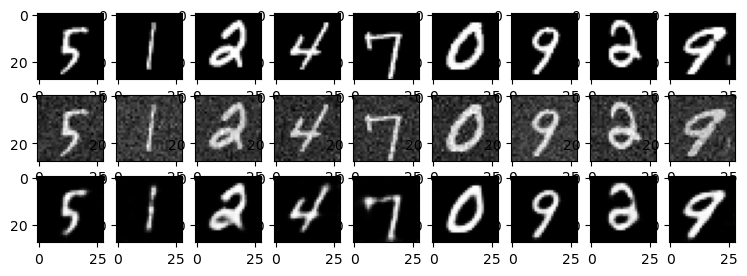

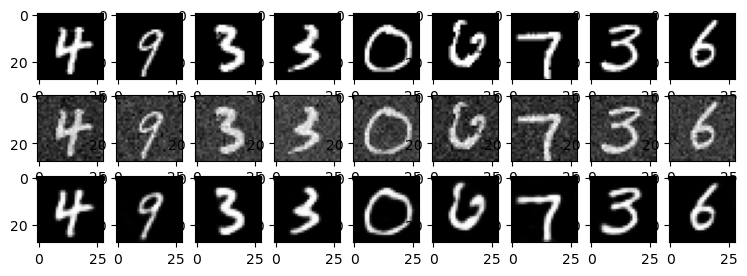

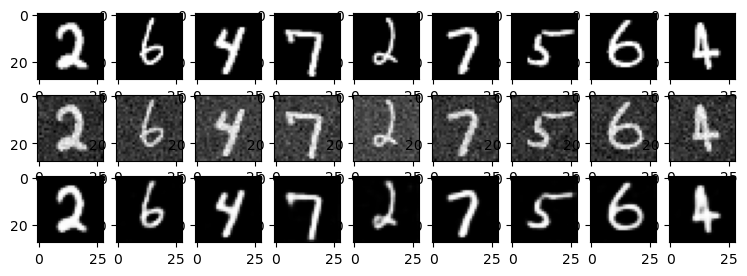

In [17]:
for k in range(0, num_epochs, 4): 
    plt.figure(figsize=(9, 3)) 
    plt.gray() 
    imgs = outputs[k][1].detach().cpu().numpy()  # Convierte a numpy para visualización
    recon = outputs[k][2].detach().cpu().numpy() 
    noisy_imgs = add_noise(torch.tensor(imgs)).cpu().numpy()  # Agrega ruido y luego convierte a numpy

    for i, item in enumerate(imgs): 
        if i >= 9: break 
        plt.subplot(3, 9, i+1) 
        item = item.reshape(28, 28)  
        plt.imshow(item, cmap='gray') 

    for i, item in enumerate(noisy_imgs):
        if i >= 9: break
        plt.subplot(3, 9, 9 + i + 1)  
        item = item.reshape(28, 28)
        plt.imshow(item, cmap='gray')

    for i, item in enumerate(recon): 
        if i >= 9: break
        plt.subplot(3, 9, 18 + i + 1)  
        item = item.reshape(28, 28)
        plt.imshow(item, cmap='gray')

    plt.show()  


### Pruebas sobre el conjunto de validación

Aquí, se evalúa el modelo en un único lote de imágenes del conjunto de validación

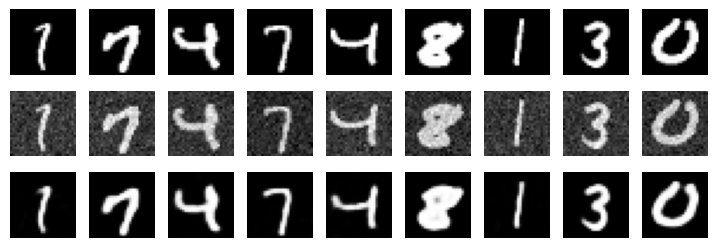

In [20]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(9, 3))  
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        noisy_img = add_noise(img)  
        pred = model(noisy_img)  
        
        recon = pred.cpu().numpy()  

        # Subplot para la imagen original
        plt.subplot(3, 9, i+1)  # Primera fila para imágenes originales
        plt.imshow(img.squeeze(), cmap='gray')  
        plt.axis('off')

        # Subplot para la imagen con ruido
        plt.subplot(3, 9, 9 + i + 1)  # Segunda fila para imágenes con ruido
        noisy_img_np = noisy_img.squeeze().cpu().numpy()  
        plt.imshow(noisy_img_np, cmap='gray')
        plt.axis('off')

        # Subplot para la imagen reconstruida
        plt.subplot(3, 9, 18 + i + 1)  
        plt.imshow(recon[0].squeeze(), cmap='gray')  
        plt.axis('off')

plt.show()